### Jupyter notebook for predicting the QMDFAM atomic multipole moment test set labels using trained PILNet model(s).

Note: Run the code in this notebook in the same conda environment generated by the install.sh bash file.<br>
Please refer to the README for further details.

In [1]:
import numpy as np
import torch

import dgl
from dgl.data.utils import load_graphs

import sys
import os
import math
import copy

import matplotlib.pyplot as plt

In [2]:
# Add parent folder (PILNet) to path to import the following functions/packages
sys.path.append(os.path.abspath("..")) 

In [3]:
from PILNet.training.TrainNetwork import (
    detrace_atomic_quadrupole_labels,
    detrace_atomic_octupole_labels,
    detrace_quadrupoles,
    detrace_octupoles,
)
from PILNet.model.PILNet import PILNet

from PILNet.inference.PredictNetwork import (
    load_format_dataset,
    load_test_dataset,
    print_testing_statistics,
    get_reference_molecular_moments,
    approximate_molecular_dipole_moment,
)

In [4]:
read_filepath_splits = "../data/splits/"
read_filepath_model = "../saved_models/trained_models/"

In [5]:
def test_network(
    device: torch.device,
    bestmodel_paths: list[str],
    testgraphs: list[dgl.DGLGraph],
    test_bsz: int,
    model_type: str,
    multipole_names: list[str],
) -> tuple[list[np.ndarray], list[np.ndarray]]:
    """
    Function for making predictions on test set using trained model(s).

    NOTE: This code assumes the feature and label orders determined in ExtractFeatures.py
        e.g., The one-hot encoded elment-type feature is accessible as:
            testbgs.ndata['nfeats'][:,0:7]
        e.g., The model returns label predictions in the order:
            atomic monopole, dipole, quadrupole, and then octupole

    Parameters
    -------
    device: torch.device
        Either a cpu or cuda device.
    bestmodel_paths: list[str]
        Path where best trained models are stored.
    testgraphs: list
        List of test set graphs.
    test_bsz: int
        Batch size to use when processing data when performing model inference.
    model_type: str
        Whether the model is a "PINN" or Non-PINN" model.
    multipole_names: list[str]
        List of names of multipole moments on which to perform evaluation

    Returns
    ----------
    true_labels_by_multipole: list[np.ndarray]
        List of reference multipole values,
            grouped by multipole type.
    pred_labels_by_multipole: list[np.ndarray],
        List of predicted multipole values,
            grouped by multipole type.

    """

    print("Performing model inference...", flush=True)

    # Create lists to store MAE and R^2 computed information
    num_graphs = len(testgraphs)
    num_models = len(bestmodel_paths)
    num_multipoles = len(multipole_names)
    num_atomic_multipoles = 4

    overall_MAE = np.zeros((num_models, num_multipoles))
    overall_R2 = np.zeros((num_models, num_multipoles))

    # Iterate over each trained model
    print(
        "\n** Predictive errors averaged across {} model(s): **".format(num_models),
        flush=True,
    )

    for i in range(num_models):

        print("\nModel path: {}".format(bestmodel_paths[i]), flush=True)

        checkpoint = torch.load(bestmodel_paths[i])
        model_param = checkpoint["model_parameters"]
        model = PILNet(model_param[0], model_param[1], model_param[2], model_type).to(device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()

        predlabels = torch.zeros(0).to(device)
        predlabels_mol_dipole = torch.zeros(0).to(device)
        num_batches = math.ceil(num_graphs / test_bsz)

        # Iterate over each batch of graphs
        start = 0
        end = test_bsz
        for j in range(num_batches):

            with torch.no_grad():

                # Obtain prediction labels
                testbgs = dgl.batch(testgraphs[start:end])
                preds = model(testbgs)

                # If model is of type PINN, approximate the molecular dipole moment
                if model_type == "PINN":

                    pred_monopoles = preds[:, 0:1]
                    pred_dipoles = preds[:, 1:4]
                    coordinates = testbgs.ndata["coordinates"]

                    # Approximate the molecular dipole moment
                    preds_mol_dipole = approximate_molecular_dipole_moment(
                        copy.deepcopy(testbgs),
                        pred_monopoles,
                        pred_dipoles,
                        coordinates,  # type: ignore
                    )

                    predlabels_mol_dipole = torch.cat(
                        (predlabels_mol_dipole, preds_mol_dipole)
                    )

                predlabels = torch.cat((predlabels, preds))

            start = end
            end += test_bsz
            

        # Convert format of dataset reference labels for atomic dipoles
        testbgs = dgl.batch(testgraphs)

        true_monopoles = testbgs.ndata["label_monopoles"].cpu().numpy()  # type: ignore
        true_dipoles = testbgs.ndata["label_dipoles"].cpu().numpy()  # type: ignore
        true_quadrupoles = testbgs.ndata["label_quadrupoles"].cpu().numpy()  # type: ignore
        true_octupoles = testbgs.ndata["label_octupoles"].cpu().numpy()  # type: ignore

        pred_monopoles = predlabels[:, 0:1]
        pred_dipoles = predlabels[:, 1:4]
        pred_quadrupoles = predlabels[:, 4:10]
        pred_octupoles = predlabels[:, 10:20]
        
        coordinates = testbgs.ndata["coordinates"]

        batch_num_nodes = testbgs.batch_num_nodes()
        sum_batch_num_nodes = copy.deepcopy(batch_num_nodes)

        running_sum = 0
        for j in range(len(sum_batch_num_nodes)):
            sum_batch_num_nodes[j] = running_sum
            running_sum += batch_num_nodes[j]

        # If model is of type PINN, obtain molecular dipole, quadrupole,
        # and octupole moments for each molecule
        if model_type == "PINN":

            testbgs.ndata["pred_monopoles"] = pred_monopoles
            testbgs.ndata["pred_dipoles"] = pred_dipoles
            testbgs.ndata["pred_quadrupoles"] = pred_quadrupoles
            testbgs.ndata["pred_octupoles"] = pred_octupoles

            predlabels_mol_dipole = predlabels_mol_dipole.cpu().numpy()

            true_mol_dipole = get_reference_molecular_moments(
                testbgs, "molecular_dipole"
            )

            true_mol_dipole = true_mol_dipole.cpu().numpy()

        # Organize reference and predicted labels in lists
        true_labels_by_multipole = [
            true_monopoles,
            true_dipoles,
            true_quadrupoles,
            true_octupoles,
        ]

        pred_monopoles = pred_monopoles.cpu().numpy()
        pred_dipoles = pred_dipoles.cpu().numpy()
        pred_quadrupoles = pred_quadrupoles.cpu().numpy()
        pred_octupoles = pred_octupoles.cpu().numpy()
        predlabels = predlabels.cpu().numpy()

        pred_labels_by_multipole = [
            pred_monopoles,
            pred_dipoles,
            pred_quadrupoles,
            pred_octupoles,
        ]
        
        if model_type == "PINN":
            true_labels_by_multipole.extend(
                [true_mol_dipole]
            )
            pred_labels_by_multipole.extend(
                [
                    predlabels_mol_dipole,
                ]
            )  # type: ignore

        # Record MAE and R^2 for each multipole type
        for j in range(len(multipole_names)):
            MAE, R2, _, _, _, _, _ = print_testing_statistics(
                true_labels_by_multipole[j], pred_labels_by_multipole[j]
            )
            overall_MAE[i, j] = MAE
            overall_R2[i, j] = R2

    print("\n\nOVERALL RESULTS", flush=True)
    for j in range(len(multipole_names)):
        print("\nMultipole type: {}".format(multipole_names[j]), flush=True)
        print("MAE: {}".format(np.mean(overall_MAE[:, j])), flush=True)
        print("R^2: {}".format(np.mean(overall_R2[:, j])), flush=True)

        print(
            "Stdev of MAE across all models: {}".format(np.std(overall_MAE[:, j])),
            flush=True,
        )
        print(
            "Stdev of R^2 across all models: {}".format(np.std(overall_R2[:, j])),
            flush=True,
        )
    
    # Return the pred labels produced by the final processed model
    return true_labels_by_multipole, pred_labels_by_multipole

In [6]:
def plot_overall_r2_results(
    true_labels_by_multipole: list[np.ndarray], 
    pred_labels_by_multipole: list[np.ndarray], 
    multipole_names: list[str]
)-> None:
    """
    Function to plot the coefficient of determination between the reference and predicted labels

    Parameters
    -------
    true_labels_by_multipole: list[np.ndarray]
        List of reference multipole values,
            grouped by multipole type.
    pred_labels_by_multipole: list[np.ndarray],
        List of predicted multipole values,
            grouped by multipole type.
    multipole_names: list[str]
        List of names of multipoles types contained in the above lists.

    Returns
    ----------
    None

    """
    
    fig, ax = plt.subplots(4, figsize=(8, 12))
    font_size = 20

    yaxis_units = ["e", "eA", "e$A^2$", "e$A^3$", "eA"]
    colors = ["indianred", "forestgreen", "steelblue", "darkorchid"]

    for i in range(len(true_labels_by_multipole)):
        x = true_labels_by_multipole[i].flatten('F')
        y = pred_labels_by_multipole[i].flatten('F')
        
        ax[i].scatter(x, y, c=colors[i], rasterized=True)
        ax[i].plot(x, x, color="black", label="y = x")
        ax[i].grid()

        ax[i].tick_params(axis='x', labelsize=font_size-2)
        ax[i].tick_params(axis='y', labelsize=font_size-2)

        ax[i].set_title(multipole_names[i], fontsize=font_size+2)
        ax[i].set_xlabel("References (" + yaxis_units[i] + ")", fontsize=font_size)
        ax[i].set_ylabel("Predictions (" + yaxis_units[i] + ")", fontsize=font_size)
        ax[i].legend(loc='lower right')

    plt.suptitle("Atomic Multipole Predicted vs. Reference Values", fontsize=font_size+4)
    fig.tight_layout()
    plt.subplots_adjust(top=0.91, hspace=0.8)
    plt.show()

In [7]:
def run_program(read_filepath_splits: str, read_filepath_model: str):
    """
    Main function for performing inference on a trained PIL-Net model.

    Parameters
    ----------
    read_filepath_splits: str
        Path to test set file.
    read_filepath_model: str
        Path to saved model(s).

    Returns
    -------
    model_type: str
        Whether the PILNet model is of type "PINN" or Non-PINN".
    true_labels_by_multipole: list[np.ndarray]
        List of reference multipole values,
            grouped by multipole type.
    pred_labels_by_multipole: list[np.ndarray],
        List of predicted multipole values,
            grouped by multipole type.
    multipole_names: list[str]
        List of names of multipole moments on which to perform evaluation

    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_path = read_filepath_splits + "testdata.bin"
    
    # Include more paths here to average result over multiple models
    bestmodel_paths = []
    for filename in os.listdir(read_filepath_model):
        if filename.endswith(".bin"):
            bestmodel_paths.append(read_filepath_model + filename)

    # Details related to neural network
    test_bsz = 2**10

    # PINN vs. Non-PINN has different predictive properties
    model_type = "PINN"
    # model_type = "Non-PINN"
    print(f"Model type: {model_type}")

    if model_type == "PINN":
        multipole_names = [
            "Monopoles",
            "Dipoles",
            "Quadrupoles",
            "Octupoles",
            "Molecular Dipole",
        ]
    elif model_type == "Non-PINN":
        multipole_names = ["Monopoles", "Dipoles", "Quadrupoles", "Octupoles"]

    # Load test dataset
    model_precision = torch.float32
    testgraphs = load_format_dataset(device, test_path, model_precision)

    # Evaluate trained model on test set graphs
    true_labels_by_multipole, pred_labels_by_multipole = test_network(
        device,
        bestmodel_paths,
        testgraphs,
        test_bsz,
        model_type,
        multipole_names,
    )
    
    if model_type == "PINN":
        del true_labels_by_multipole[-1]
        del multipole_names[-1]
        
    return model_type, true_labels_by_multipole, pred_labels_by_multipole, multipole_names

In [8]:
model_type, true_labels_by_multipole, pred_labels_by_multipole, multipole_names = run_program(
    read_filepath_splits, 
    read_filepath_model
)

Model type: PINN

Reading in dataset...
Formatting dataset...
Performing model inference...

** Predictive errors averaged across 3 model(s): **

Model path: ../saved_models/trained_models/pilnet_model1.bin

Model path: ../saved_models/trained_models/pilnet_model3.bin

Model path: ../saved_models/trained_models/pilnet_model2.bin


OVERALL RESULTS

Multipole type: Monopoles
MAE: 0.007438763044774532
R^2: 0.9988147737070298
Stdev of MAE across all models: 4.7208060610703386e-05
Stdev of R^2 across all models: 1.578233953620726e-05

Multipole type: Dipoles
MAE: 0.002000046195462346
R^2: 0.9839121922850609
Stdev of MAE across all models: 3.7534657479341766e-05
Stdev of R^2 across all models: 0.0005950109757348948

Multipole type: Quadrupoles
MAE: 0.001181884086690843
R^2: 0.9793902151286602
Stdev of MAE across all models: 6.246644064828774e-06
Stdev of R^2 across all models: 0.00025793944702734976

Multipole type: Octupoles
MAE: 0.0013227255161230762
R^2: 0.9776676011582216
Stdev of MAE ac

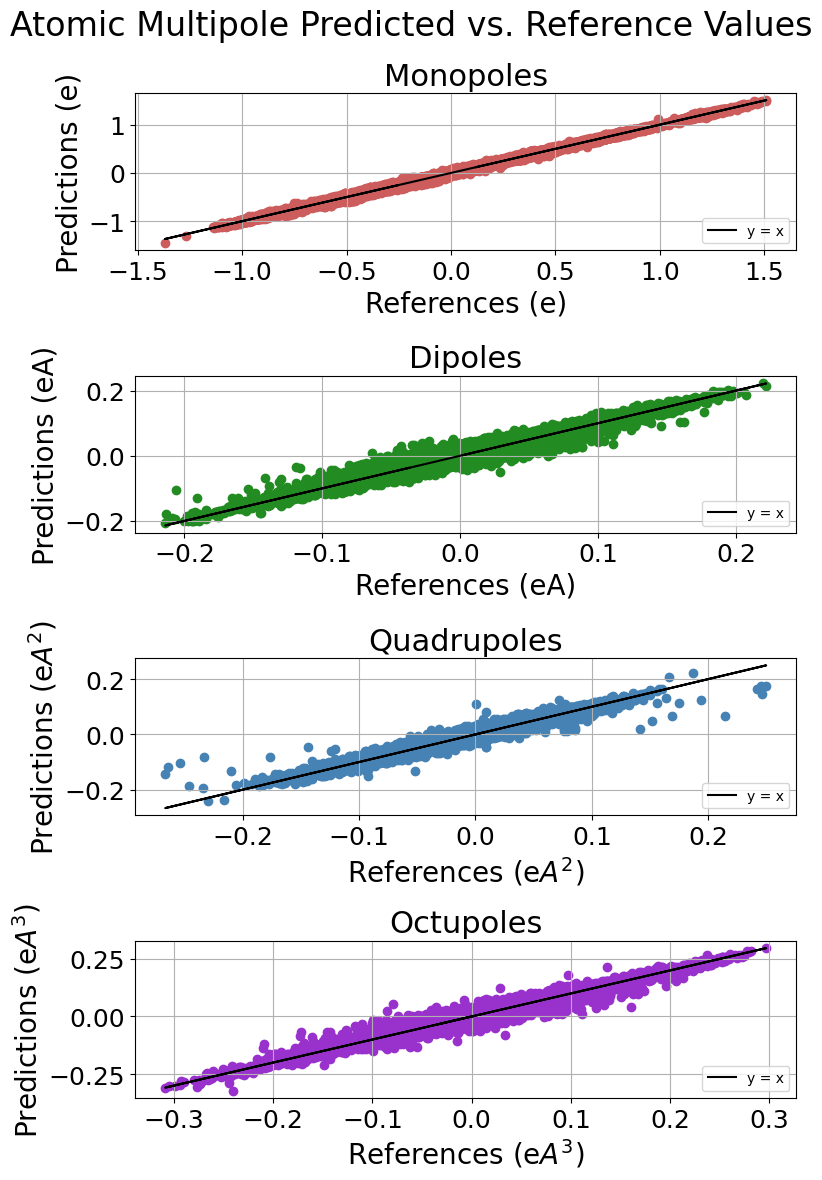

In [9]:
plot_overall_r2_results(true_labels_by_multipole, pred_labels_by_multipole, multipole_names)